In [4]:
# !pip install mediapipe --q
!pip install -q git+https://github.com/hoyso48/tf-utils@main

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("risangbaskoro/wlasl-processed")

print("Path to dataset files:", path)

In [2]:
import pandas as pd
import numpy as np
import json
import os
import sys
from glob import glob
from pathlib import Path
from IPython.display import Video,display
from tqdm.auto import tqdm
from PIL import Image
tqdm.pandas()
from multiprocessing import Pool
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow.keras.mixed_precision as mixed_precision
import sklearn
from tf_utils.schedules import OneCycleLR, ListedLR
from tf_utils.callbacks import Snapshot, SWA
from tf_utils.learners import FGM, AWP

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D0818 23:43:50.411272603      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0818 23:43:50.411296621      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0818 23:43:50.411299851      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0818 23:43:50.411302588      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0818 23:43:50.411304876      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0818 23:43:50.411307597      15 config.cc:119]     

In [3]:
rootin = '/kaggle/input/wlasl-processed'
rootout= '/kaggle/working/'
video_path = os.path.join(rootin,'videos')
nslt_100_json =  os.path.join(rootin,'nslt_100.json')

In [4]:
# import os
# import cv2
# import pandas as pd
# import mediapipe as mp
# import pyarrow as pa
# import pyarrow.parquet as pq
# import numpy as np

# mp_holistic = mp.solutions.holistic
# mp_drawing = mp.solutions.drawing_utils

# def process_video(video_path):
#     cap = cv2.VideoCapture(video_path)
#     with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#         features = []
#         frame_number = 0
#         while cap.isOpened():
#             ret, frame = cap.read()
#             if not ret:
#                 break

#             rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#             results = holistic.process(rgb_frame)

#             pose_landmarks = results.pose_landmarks.landmark if results.pose_landmarks else []
#             left_hand_landmarks = results.left_hand_landmarks.landmark if results.left_hand_landmarks else []
#             right_hand_landmarks = results.right_hand_landmarks.landmark if results.right_hand_landmarks else []
#             face_landmarks = results.face_landmarks.landmark if results.face_landmarks else []

#             for landmark_index in range(33):  # Assuming 33 pose landmarks
#                 landmark = pose_landmarks[landmark_index] if landmark_index < len(pose_landmarks) else None
#                 features.append({
#                     'frame': frame_number,
#                     'row_id': f'{frame_number}-pose-{landmark_index}',
#                     'type': 'pose',
#                     'landmark_index': landmark_index,
#                     'x': landmark.x if landmark and landmark.visibility > 0 else np.nan,
#                     'y': landmark.y if landmark and landmark.visibility > 0 else np.nan,
#                     'z': landmark.z if landmark and landmark.visibility > 0 else np.nan
#                 })

#             for landmark_index in range(21):  # Assuming 21 hand landmarks
#                 left_hand_landmark = left_hand_landmarks[landmark_index] if landmark_index < len(left_hand_landmarks) else None
#                 right_hand_landmark = right_hand_landmarks[landmark_index] if landmark_index < len(right_hand_landmarks) else None
#                 features.append({
#                     'frame': frame_number,
#                     'row_id': f'{frame_number}-left_hand-{landmark_index}',
#                     'type': 'left_hand',
#                     'landmark_index': landmark_index,
#                     'x': left_hand_landmark.x if left_hand_landmark else np.nan,
#                     'y': left_hand_landmark.y if left_hand_landmark else np.nan,
#                     'z': left_hand_landmark.z if left_hand_landmark else np.nan
#                 })

#                 features.append({
#                     'frame': frame_number,
#                     'row_id': f'{frame_number}-right_hand-{landmark_index}',
#                     'type': 'right_hand',
#                     'landmark_index': landmark_index,
#                     'x': right_hand_landmark.x if right_hand_landmark else np.nan,
#                     'y': right_hand_landmark.y if right_hand_landmark else np.nan,
#                     'z': right_hand_landmark.z if right_hand_landmark else np.nan
#                 })

#             for landmark_index in range(468):  # Assuming 468 face landmarks
#                 landmark = face_landmarks[landmark_index] if landmark_index < len(face_landmarks) else None
#                 features.append({
#                     'frame': frame_number,
#                     'row_id': f'{frame_number}-face-{landmark_index}',
#                     'type': 'face',
#                     'landmark_index': landmark_index,
#                     'x': landmark.x if landmark else np.nan,
#                     'y': landmark.y if landmark else np.nan,
#                     'z': landmark.z if landmark else np.nan
#                 })

#             frame_number += 1

#         cap.release()
#         return features

# def save_features_to_parquet(features, output_file):
#     df = pd.DataFrame(features)
#     table = pa.Table.from_pandas(df)
#     pq.write_table(table, output_file)
#     del features
# def run(video_file):
#     check_file = os.path.join('/kaggle/input/wlasl-landmarks/wlasl', f"{os.path.splitext(os.path.basename(video_file))[0]}.parquet")

#     if video_file.endswith(".mp4") and not os.path.exists(check_file):

#         video_file = os.path.join(input_directory, video_file)
#         output_file = os.path.join(output_directory, f"{os.path.splitext(os.path.basename(video_file))[0]}.parquet")

#         features = process_video(video_file)
#         save_features_to_parquet(features, output_file)
# input_directory = video_path
# output_directory = rootout+"/landmarks_files"
# os.makedirs(output_directory,exist_ok = True)
# # for video_file in tqdm(os.listdir(input_directory)):
# # pool = Pool()
# # pool.map(run, tqdm())
# # pool.close()
# #     break
# from multiprocessing import Pool
# if __name__ == '__main__':
#     with Pool(processes=8) as p:
#         with tqdm(total=len(os.listdir(input_directory))) as pbar:
#             for _ in p.imap_unordered(run, os.listdir(input_directory)):
#                 pbar.update()

In [5]:
# %cp -r /kaggle/input/wlasl-landmarks/wlasl/* {output_directory}

In [6]:
# pd.concat([pd.read_json("/kaggle/input/wlasl-processed/WLASL_v0.3.json")['gloss'],pd.DataFrame(pd.read_json("/kaggle/input/wlasl-processed/WLASL_v0.3.json")['instances'].to_dict()[0])],axis = 1).dropna()

In [7]:
# def get_videos_ids(json_list):
#     """
#     function to check if the video id is available in the dataset
#     and return the viedos ids of the current instance
    
#     input: instance json list
#     output: list of videos_ids
    
#     """
#     videos_list = []    
#     for ins in json_list:
#         video_id = ins['video_id']
#         if os.path.exists(f'{rootin}/videos/{video_id}.mp4'):
#             videos_list.append(video_id)
#     return videos_list
# def get_json_features(json_list):
#     """
#     function to check if the video id is available in the dataset
#     and return the viedos ids and url or any other featrue of the current instance
    
#     input: instance json list
#     output: list of videos_ids
    
#     """
#     videos_ids = []
#     videos_urls = []
#     videos_bbox = []
#     videos_fps = []
#     videos_frame_end = []
#     videos_frame_start = []
#     videos_signer_id = []
#     videos_source = []
#     videos_split = []
#     videos_variation_id = []
#     for ins in json_list:
      
#         video_id = ins['video_id']
#         video_url = ins['url']
#         video_bbox = ins['bbox']
#         video_fps = ins['fps']
#         video_frame_end = ins['frame_end']
#         video_frame_start = ins['frame_start']
#         video_signer_id = ins['signer_id']
#         video_source = ins['source']
#         video_split = ins['split']
#         video_variation_id = ins['variation_id']
#         if os.path.exists(f'{rootin}/videos/{video_id}.mp4'):
#             videos_ids.append(video_id)
#             videos_urls.append(video_url)
#             videos_bbox.append(video_bbox)
#             videos_fps.append(video_fps)
#             videos_frame_end.append(video_frame_end)
#             videos_frame_start.append(video_frame_start)
#             videos_signer_id.append(video_signer_id)
#             videos_source.append(video_source)
#             videos_split.append(video_split)
#             videos_variation_id.append(video_variation_id)
#     return videos_ids, videos_urls, videos_bbox, videos_fps, videos_frame_end, videos_frame_start, videos_signer_id, videos_source, videos_split,videos_variation_id
# with open('/kaggle/input/wlasl-processed/WLASL_v0.3.json', 'r') as data_file:
#     json_data = data_file.read()
# wlasl_df = pd.read_json(rootin + '/WLASL_v0.3.json')
# instance_json = json.loads(json_data)
# get_videos_ids(instance_json[0]['instances'])[0]
# wlasl_df['videos_ids'] = wlasl_df['instances'].progress_apply(get_videos_ids)

In [8]:
# features_df = pd.DataFrame(columns=['gloss', 'video_id', 'urls', 'bbox', 'fps', 'frame_end', 'frame_start','signer_id', 'source', 'split', 'variation_id'])
# for row in tqdm(wlasl_df.iterrows(),total = wlasl_df.shape[0]):
#     ids, urls, bbox, fps, frame_end, frame_start,signer_id, source, split, variation_id = get_json_features(row[1][1])
#     word = [row[1][0]] * len(ids)
#     df = pd.DataFrame(list(zip(word, ids, urls, bbox, fps, frame_end, frame_start, signer_id, source, split, variation_id)), columns=features_df.columns)
#     features_df = features_df.append(df, ignore_index=True)
# features_df['video_id'] = features_df['video_id'].astype(int)

In [9]:
# features_df.to_csv("main.csv")

In [10]:
import numpy as np
import tensorflow as tf
ROWS_PER_FRAME = 543
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path).sort_values(['frame','type','landmark_index'])
    data = data[data_columns]
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)
def encode_row(row):
    coordinates = load_relevant_data_subset(row.path)
    coordinates_encoded = coordinates.tobytes()
#     participant_id = int(row.participant_id)
#     sequence_id = int(row.sequence_id)
    sign = int(row.label)

    record_bytes = tf.train.Example(features=tf.train.Features(feature={
                'coordinates': tf.train.Feature(bytes_list=tf.train.BytesList(value=[coordinates_encoded])),
#                 'participant_id': tf.train.Feature(int64_list=tf.train.Int64List(value=[participant_id])),
#                 'sequence_id':tf.train.Feature(int64_list=tf.train.Int64List(value=[sequence_id])),
                'sign':tf.train.Feature(int64_list=tf.train.Int64List(value=[sign])),
                })).SerializeToString()
    return record_bytes

def process_chunk(row):
    
    tfrecord_name = f"{output_tf_records}/{str(row['video_id']).zfill(5)}.tfrecord"
    if not os.path.exists(tfrecord_name):
        options = tf.io.TFRecordOptions(compression_type='GZIP', compression_level=9)
        with tf.io.TFRecordWriter(tfrecord_name, options=options) as file_writer:
            record_bytes = encode_row(row)
            file_writer.write(record_bytes)
            del record_bytes
            file_writer.close()

In [11]:
NUM2CHAR = dict(pd.read_csv("/kaggle/input/wlasl-processed/wlasl_class_list.txt",sep = '\t',header = None).replace('losear','lose').values.tolist())
CHAR2NUM = {v:k for k,v in NUM2CHAR.items()}

In [12]:
df = pd.read_csv("/kaggle/input/wlasl-landmarks/main.csv").drop("Unnamed: 0",axis = 1)
df['path'] = df['video_id'].progress_apply(lambda x: os.path.join("/kaggle/input/wlasl-landmarks/landmarks_files",str(x).zfill(5)+".parquet"))
df['label'] = df['gloss'].progress_apply(lambda x: CHAR2NUM.get(x))
df.head()

100%|██████████| 11980/11980 [00:00<00:00, 361715.88it/s]


,gloss,video_id,urls,bbox,fps,frame_end,frame_start,signer_id,source,split,variation_id,path,label
0,book,69241,http://aslbricks.org/New/ASL-Videos/book.mp4,"[385, 37, 885, 720]",25,-1,1,118,aslbrick,train,0,/kaggle/input/wlasl-landmarks/landmarks_files/...,0
1,book,7069,https://signstock.blob.core.windows.net/signsc...,"[462, 44, 949, 720]",25,-1,1,31,signschool,train,0,/kaggle/input/wlasl-landmarks/landmarks_files/...,0
2,book,7068,https://s3-us-west-1.amazonaws.com/files.start...,"[234, 17, 524, 414]",25,-1,1,36,startasl,train,0,/kaggle/input/wlasl-landmarks/landmarks_files/...,0
3,book,7070,https://media.asldeafined.com/vocabulary/14666...,"[131, 26, 526, 480]",25,-1,1,59,asldeafined,train,0,/kaggle/input/wlasl-landmarks/landmarks_files/...,0
4,book,7099,http://www.aslsearch.com/signs/videos/book.mp4,"[162, 54, 528, 400]",25,-1,1,12,aslsearch,val,0,/kaggle/input/wlasl-landmarks/landmarks_files/...,0


In [13]:
# output_tf_records = '/kaggle/working/landmarks_tf_records'
# os.makedirs(output_tf_records,exist_ok = True)
# for idx,row in tqdm(df.iterrows(),total = df.shape[0]):
#     process_chunk(row)
# #     break

In [14]:
os.environ['KAGGLE_USERNAME'] = 'glitchr'
os.environ['KAGGLE_KEY']  = '1f780208f5233dc5ac7fc4e130217992'

In [15]:
# import shutil
# shutil.make_archive('landmarks_files', format='zip',
#                     root_dir='/kaggle/input/wlasl-landmarks', base_dir='landmarks_files')

In [16]:
# !rm -rf /kaggle/working/landmarks_files.zip

In [17]:
# %cp -r /kaggle/input/wlasl-landmarks/main.csv /kaggle/working/

In [18]:
# !kaggle datasets init -p /kaggle/working/

In [19]:
# import json
# json.load(open("/kaggle/working/dataset-metadata.json",'r'))

In [20]:
# meta_data = {
#     'title': 'wlasl-data-feature-extracted',
#     'id': 'glitchr/wlasl-data-feature-extracted',
#     'licenses': [{'name': 'CC0-1.0'}]
# }

In [21]:
# json.dump(meta_data,open("/kaggle/working/dataset-metadata.json",'w'),indent = 4)

In [22]:
# json.load(open("/kaggle/working/dataset-metadata.json",'r'))

In [23]:
# %cp -r /kaggle/input/wlasl-landmarks/* /kaggle/working/

In [24]:
# !kaggle datasets create -p /kaggle/working/ --dir-mode 'zip'

In [73]:
ROWS_PER_FRAME = 543
MAX_LEN = 58
CROP_LEN = MAX_LEN
NUM_CLASSES  = 2000
PAD = -100.
NOSE=[
    1,2,98,327
]
LNOSE = [98]
RNOSE = [327]
LIP = [ 0, 
    61, 185, 40, 39, 37, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]
LLIP = [84,181,91,146,61,185,40,39,37,87,178,88,95,78,191,80,81,82]
RLIP = [314,405,321,375,291,409,270,269,267,317,402,318,324,308,415,310,311,312]

POSE = [500, 502, 504, 501, 503, 505, 512, 513]
LPOSE = [513,505,503,501]
RPOSE = [512,504,502,500]

REYE = [
    33, 7, 163, 144, 145, 153, 154, 155, 133,
    246, 161, 160, 159, 158, 157, 173,
]
LEYE = [
    263, 249, 390, 373, 374, 380, 381, 382, 362,
    466, 388, 387, 386, 385, 384, 398,
]

LHAND = np.arange(468, 489).tolist()
RHAND = np.arange(522, 543).tolist()

POINT_LANDMARKS = LIP + LHAND + RHAND + NOSE + REYE + LEYE #+POSE

NUM_NODES = len(POINT_LANDMARKS)
CHANNELS = 6*NUM_NODES
CHANNELS = 2*NUM_NODES


print(NUM_NODES)
print(CHANNELS)

def interp1d_(x, target_len, method='random'):
    length = tf.shape(x)[1]
    target_len = tf.maximum(1,target_len)
    if method == 'random':
        if tf.random.uniform(()) < 0.33:
            x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'bilinear')
        else:
            if tf.random.uniform(()) < 0.5:
                x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'bicubic')
            else:
                x = tf.image.resize(x, (target_len,tf.shape(x)[1]),'nearest')
    else:
        x = tf.image.resize(x, (target_len,tf.shape(x)[1]),method)
    return x

def tf_nan_mean(x, axis=0, keepdims=False):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis, keepdims=keepdims) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis, keepdims=keepdims)

def tf_nan_std(x, center=None, axis=0, keepdims=False):
    if center is None:
        center = tf_nan_mean(x, axis=axis,  keepdims=True)
    d = x - center
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis, keepdims=keepdims))

class Preprocess(tf.keras.layers.Layer):
    def __init__(self, max_len=MAX_LEN, point_landmarks=POINT_LANDMARKS, **kwargs):
        super().__init__(**kwargs)
        self.max_len = max_len
        self.point_landmarks = point_landmarks

    def call(self, inputs):
        if tf.rank(inputs) == 3:
            x = inputs[None,...]
        else:
            x = inputs
        
        mean = tf_nan_mean(tf.gather(x, [17], axis=2), axis=[1,2], keepdims=True)
        mean = tf.where(tf.math.is_nan(mean), tf.constant(0.5,x.dtype), mean)
        x = tf.gather(x, self.point_landmarks, axis=2) #N,T,P,C
        std = tf_nan_std(x, center=mean, axis=[1,2], keepdims=True)
        
        x = (x - mean)/std

        if self.max_len is not None:
            x = x[:,:self.max_len]
        length = tf.shape(x)[1]
        x = x[...,:2]

#         dx = tf.cond(tf.shape(x)[1]>1,lambda:tf.pad(x[:,1:] - x[:,:-1], [[0,0],[0,1],[0,0],[0,0]]),lambda:tf.zeros_like(x))

#         dx2 = tf.cond(tf.shape(x)[1]>2,lambda:tf.pad(x[:,2:] - x[:,:-2], [[0,0],[0,2],[0,0],[0,0]]),lambda:tf.zeros_like(x))

#         x = tf.concat([
#             tf.reshape(x, (-1,length,2*len(self.point_landmarks))),
#             tf.reshape(dx, (-1,length,2*len(self.point_landmarks))),
#             tf.reshape(dx2, (-1,length,2*len(self.point_landmarks))),
#         ], axis = -1)
        x =  tf.reshape(x, (-1,length,2*len(self.point_landmarks)))

        x = tf.where(tf.math.is_nan(x),tf.constant(0.,x.dtype),x)
        
        return x
def decode_tfrec(record_bytes):
    features = tf.io.parse_single_example(record_bytes, {
        'coordinates': tf.io.FixedLenFeature([], tf.string),
        'sign': tf.io.FixedLenFeature([], tf.int64),
    })
    out = {}
    out['coordinates']  = tf.reshape(tf.io.decode_raw(features['coordinates'], tf.float32), (-1,ROWS_PER_FRAME,3))
    out['sign'] = features['sign']
    return out

def filter_nans_tf(x, ref_point=POINT_LANDMARKS):
    mask = tf.math.logical_not(tf.reduce_all(tf.math.is_nan(tf.gather(x,ref_point,axis=1)), axis=[-2,-1]))
    x = tf.boolean_mask(x, mask, axis=0)
    return x

def preprocess(x, augment=False, max_len=MAX_LEN,NUM_C = NUM_CLASSES):
    coord = x['coordinates']
    coord = filter_nans_tf(coord)
    if augment:
        coord = augment_fn(coord, max_len=max_len)
    coord = tf.ensure_shape(coord, (None,ROWS_PER_FRAME,3))
    
    return tf.cast(Preprocess(max_len=max_len)(coord)[0],tf.float32), tf.one_hot(x['sign'], NUM_C)

def flip_lr(x):
    x,y,z = tf.unstack(x, axis=-1)
    x = 1-x
    new_x = tf.stack([x,y,z], -1)
    new_x = tf.transpose(new_x, [1,0,2])
    lhand = tf.gather(new_x, LHAND, axis=0)
    rhand = tf.gather(new_x, RHAND, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LHAND)[...,None], rhand)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RHAND)[...,None], lhand)
    llip = tf.gather(new_x, LLIP, axis=0)
    rlip = tf.gather(new_x, RLIP, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LLIP)[...,None], rlip)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RLIP)[...,None], llip)
    lpose = tf.gather(new_x, LPOSE, axis=0)
    rpose = tf.gather(new_x, RPOSE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LPOSE)[...,None], rpose)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RPOSE)[...,None], lpose)
    leye = tf.gather(new_x, LEYE, axis=0)
    reye = tf.gather(new_x, REYE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LEYE)[...,None], reye)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(REYE)[...,None], leye)
    lnose = tf.gather(new_x, LNOSE, axis=0)
    rnose = tf.gather(new_x, RNOSE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LNOSE)[...,None], rnose)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RNOSE)[...,None], lnose)
    new_x = tf.transpose(new_x, [1,0,2])
    return new_x

def resample(x, rate=(0.8,1.2)):
    rate = tf.random.uniform((), rate[0], rate[1])
    length = tf.shape(x)[0]
    new_size = tf.cast(rate*tf.cast(length,tf.float32), tf.int32)
    new_x = interp1d_(x, new_size)
    return new_x

def spatial_random_affine(xyz,
    scale  = (0.8,1.2),
    shear = (-0.15,0.15),
    shift  = (-0.1,0.1),
    degree = (-30,30),
):
    center = tf.constant([0.5,0.5])
    if scale is not None:
        scale = tf.random.uniform((),*scale)
        xyz = scale*xyz

    if shear is not None:
        xy = xyz[...,:2]
        z = xyz[...,2:]
        shear_x = shear_y = tf.random.uniform((),*shear)
        if tf.random.uniform(()) < 0.5:
            shear_x = 0.
        else:
            shear_y = 0.
        shear_mat = tf.identity([
            [1.,shear_x],
            [shear_y,1.]
        ])
        xy = xy @ shear_mat
        center = center + [shear_y, shear_x]
        xyz = tf.concat([xy,z], axis=-1)

    if degree is not None:
        xy = xyz[...,:2]
        z = xyz[...,2:]
        xy -= center
        degree = tf.random.uniform((),*degree)
        radian = degree/180*np.pi
        c = tf.math.cos(radian)
        s = tf.math.sin(radian)
        rotate_mat = tf.identity([
            [c,s],
            [-s, c],
        ])
        xy = xy @ rotate_mat
        xy = xy + center
        xyz = tf.concat([xy,z], axis=-1)

    if shift is not None:
        shift = tf.random.uniform((),*shift)
        xyz = xyz + shift

    return xyz

def temporal_crop(x, length=MAX_LEN):
    l = tf.shape(x)[0]
    offset = tf.random.uniform((), 0, tf.clip_by_value(l-length,1,length), dtype=tf.int32)
    x = x[offset:offset+length]
    return x

def temporal_mask(x, size=(0.2,0.4), mask_value=float('nan')):
    l = tf.shape(x)[0]
    mask_size = tf.random.uniform((), *size)
    mask_size = tf.cast(tf.cast(l, tf.float32) * mask_size, tf.int32)
    mask_offset = tf.random.uniform((), 0, tf.clip_by_value(l-mask_size,1,l), dtype=tf.int32)
    x = tf.tensor_scatter_nd_update(x,tf.range(mask_offset, mask_offset+mask_size)[...,None],tf.fill([mask_size,543,3],mask_value))
    return x

def spatial_mask(x, size=(0.2,0.4), mask_value=float('nan')):
    mask_offset_y = tf.random.uniform(())
    mask_offset_x = tf.random.uniform(())
    mask_size = tf.random.uniform((), *size)
    mask_x = (mask_offset_x<x[...,0]) & (x[...,0] < mask_offset_x + mask_size)
    mask_y = (mask_offset_y<x[...,1]) & (x[...,1] < mask_offset_y + mask_size)
    mask = mask_x & mask_y
    x = tf.where(mask[...,None], mask_value, x)
    return x

def augment_fn(x, always=False, max_len=None):
    if tf.random.uniform(())<0.8 or always:
        x = resample(x, (0.5,1.5))
    if tf.random.uniform(())<0.5 or always:
        x = flip_lr(x)
    if max_len is not None:
        x = temporal_crop(x, max_len)
    if tf.random.uniform(())<0.75 or always:
        x = spatial_random_affine(x)
    if tf.random.uniform(())<0.5 or always:
        x = temporal_mask(x)
    if tf.random.uniform(())<0.5 or always:
        x = spatial_mask(x)
    return x

def get_tfrec_dataset(tfrecords, NUM_C,batch_size=64, max_len=MAX_LEN, drop_remainder=False, augment=False, shuffle=False, repeat=False):
    # Initialize dataset with TFRecords
    ds = tf.data.TFRecordDataset(tfrecords, num_parallel_reads=tf.data.AUTOTUNE, compression_type='GZIP')
    ds = ds.map(decode_tfrec, tf.data.AUTOTUNE)
    ds = ds.map(lambda x: preprocess(x, augment=augment, max_len=max_len,NUM_C = NUM_C), tf.data.AUTOTUNE)

    if repeat: 
        ds = ds.repeat()
        
    if shuffle:
        ds = ds.shuffle(shuffle)
        options = tf.data.Options()
        options.experimental_deterministic = (False)
        ds = ds.with_options(options)
    
    if batch_size:
        ds = ds.padded_batch(batch_size, padding_values=PAD, padded_shapes=([max_len,CHANNELS],[NUM_C]), drop_remainder=drop_remainder)

    ds = ds.prefetch(tf.data.AUTOTUNE)
        
    return ds
TRAIN_FILENAMES = '/kaggle/input/wlasl-data-feature-extracted/landmarks_tf_records/00335.tfrecord'
ds = get_tfrec_dataset(TRAIN_FILENAMES,NUM_C = 100, augment=True, batch_size=1024)
for x in ds:
    temp_train = x
    break
ds

118
236


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 58, 236), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>

<_ParallelMapDataset element_spec={'coordinates': TensorSpec(shape=(None, 543, 3), dtype=tf.float32, name=None), 'sign': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


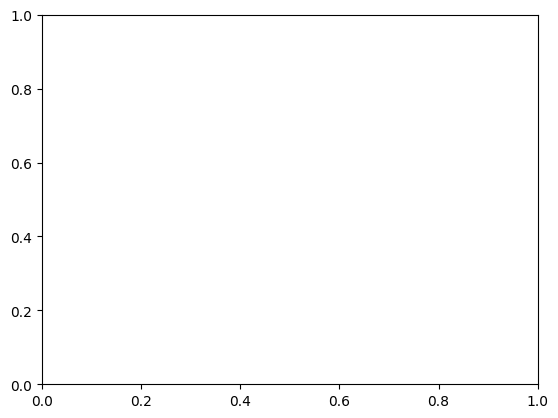

In [74]:
from IPython.display import HTML
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
def filter_nans(frames):
    return frames[~np.isnan(frames).all(axis=(-2,-1))]

ds = tf.data.TFRecordDataset(TRAIN_FILENAMES, num_parallel_reads=tf.data.AUTOTUNE, compression_type='GZIP')
ds = ds.map(decode_tfrec, tf.data.AUTOTUNE)
print(ds)
for x in ds:
    temp = x['coordinates'].numpy()
    if not len(filter_nans(temp[:,LHAND])) == 0:
        break
    
edges = [(0,1),(1,2),(2,3),(3,4),(0,5),(0,17),(5,6),(6,7),(7,8),(5,9),(9,10),(10,11),(11,12),
         (9,13),(13,14),(14,15),(15,16),(13,17),(17,18),(18,19),(19,20)]

fig, ax = plt.subplots()

def plot_frame(frame, edges=[], idxs=[]):
        
    frame[np.isnan(frame)] = 0
    x = list(frame[...,0])
    y = list(frame[...,1])
    if len(idxs) == 0:
        idxs = list(range(len(x)))
    ax.clear()
    ax.scatter(x, y, color='dodgerblue')
    for i in range(len(x)):
        ax.text(x[i], y[i], idxs[i])
        
    for edge in edges:
        ax.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], color='salmon')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

def animate_frames(frames, edges=[], idxs=[]):
    anim = FuncAnimation(fig, lambda frame: plot_frame(frame, edges, idxs), frames=frames, interval=100)
    return HTML(anim.to_jshtml())

In [75]:
animate_frames(filter_nans(temp[:,LHAND]),edges=edges)

/usr/local/lib/python3.8/site-packages/matplotlib/animation.py:1740: UserWarning: Can not start iterating the frames for the initial draw. This can be caused by passing in a 0 length sequence for *frames*.

If you passed *frames* as a generator it may be exhausted due to a previous display or save.
  warnings.warn(


In [28]:
animate_frames(filter_nans(temp[:,POINT_LANDMARKS]))

In [76]:
class ECA(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=kernel_size, strides=1, padding="same", use_bias=False)

    def call(self, inputs, mask=None):
        nn = tf.keras.layers.GlobalAveragePooling1D()(inputs, mask=mask)
        nn = tf.expand_dims(nn, -1)
        nn = self.conv(nn)
        nn = tf.squeeze(nn, -1)
        nn = tf.nn.sigmoid(nn)
        nn = nn[:,None,:]
        return inputs * nn

class LateDropout(tf.keras.layers.Layer):
    def __init__(self, rate, noise_shape=None, start_step=0, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.rate = rate
        self.start_step = start_step
        self.dropout = tf.keras.layers.Dropout(rate, noise_shape=noise_shape)
      
    def build(self, input_shape):
        super().build(input_shape)
        agg = tf.VariableAggregation.ONLY_FIRST_REPLICA
        self._train_counter = tf.Variable(0, dtype="int64", aggregation=agg, trainable=False)

    def call(self, inputs, training=False):
        x = tf.cond(self._train_counter < self.start_step, lambda:inputs, lambda:self.dropout(inputs, training=training))
        if training:
            self._train_counter.assign_add(1)
        return x

class CausalDWConv1D(tf.keras.layers.Layer):
    def __init__(self, 
        kernel_size=17,
        dilation_rate=1,
        use_bias=False,
        depthwise_initializer='glorot_uniform',
        name='', **kwargs):
        super().__init__(name=name,**kwargs)
        self.causal_pad = tf.keras.layers.ZeroPadding1D((dilation_rate*(kernel_size-1),0),name=name + '_pad')
        self.dw_conv = tf.keras.layers.DepthwiseConv1D(
                            kernel_size,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding='valid',
                            use_bias=use_bias,
                            depthwise_initializer=depthwise_initializer,
                            name=name + '_dwconv')
        self.supports_masking = True
        
    def call(self, inputs):
        x = self.causal_pad(inputs)
        x = self.dw_conv(x)
        return x

def Conv1DBlock(channel_size,
          kernel_size,
          dilation_rate=1,
          drop_rate=0.0,
          expand_ratio=2,
          se_ratio=0.25,
          activation='swish',
          name=None):
    '''
    efficient conv1d block, @hoyso48
    '''
    if name is None:
        name = str(tf.keras.backend.get_uid("mbblock"))
    # Expansion phase
    def apply(inputs):
        channels_in = tf.keras.backend.int_shape(inputs)[-1]
        channels_expand = channels_in * expand_ratio

        skip = inputs

        x = tf.keras.layers.Dense(
            channels_expand,
            use_bias=True,
            activation=activation,
            name=name + '_expand_conv')(inputs)

        # Depthwise Convolution
        x = CausalDWConv1D(kernel_size,
            dilation_rate=dilation_rate,
            use_bias=False,
            name=name + '_dwconv')(x)

        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn')(x)

        x  = ECA()(x)

        x = tf.keras.layers.Dense(
            channel_size,
            use_bias=True,
            name=name + '_project_conv')(x)

        if drop_rate > 0:
            x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop')(x)

        if (channels_in == channel_size):
            x = tf.keras.layers.add([x, skip], name=name + '_add')
        return x

    return apply
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, dim=256, num_heads=4, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.scale = self.dim ** -0.5
        self.num_heads = num_heads
        self.qkv = tf.keras.layers.Dense(3 * dim, use_bias=False)
        self.drop1 = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(dim, use_bias=False)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        qkv = self.qkv(inputs)
        qkv = tf.keras.layers.Permute((2, 1, 3))(tf.keras.layers.Reshape((-1, self.num_heads, self.dim * 3 // self.num_heads))(qkv))
        q, k, v = tf.split(qkv, [self.dim // self.num_heads] * 3, axis=-1)

        attn = tf.matmul(q, k, transpose_b=True) * self.scale

        if mask is not None:
            mask = mask[:, None, None, :]

        attn = tf.keras.layers.Softmax(axis=-1)(attn, mask=mask)
        attn = self.drop1(attn)

        x = attn @ v
        x = tf.keras.layers.Reshape((-1, self.dim))(tf.keras.layers.Permute((2, 1, 3))(x))
        x = self.proj(x)
        return x


def TransformerBlock(dim=256, num_heads=4, expand=4, attn_dropout=0.2, drop_rate=0.2, activation='swish'):
    def apply(inputs):
        x = inputs
        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = MultiHeadSelfAttention(dim=dim,num_heads=num_heads,dropout=attn_dropout)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([inputs, x])
        attn_out = x

        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = tf.keras.layers.Dense(dim*expand, use_bias=False, activation=activation)(x)
        x = tf.keras.layers.Dense(dim, use_bias=False)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([attn_out, x])
        return x
    return apply
def get_model(NC,max_len=MAX_LEN, dropout_step=0, dim=192):
    inp = tf.keras.Input((max_len,CHANNELS))
    x = tf.keras.layers.Masking(mask_value=PAD,input_shape=(max_len,CHANNELS))(inp)
    ksize = 17
    x = tf.keras.layers.Dense(dim, use_bias=False,name='stem_conv')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95,name='stem_bn')(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    if dim == 384: #for the 4x sized model
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = TransformerBlock(dim,expand=2)(x)

        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = TransformerBlock(dim,expand=2)(x)

    x = tf.keras.layers.Dense(dim*2,activation=None,name='top_conv')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = LateDropout(0.8, start_step=dropout_step)(x)
    x = tf.keras.layers.Dense(NC,name='classifier')(x)
    return tf.keras.Model(inp, x)

model = get_model(100)
# model.summary()
y = model(temp_train[0])
tf.keras.losses.CategoricalCrossentropy(from_logits=True)(temp_train[1],y)

<tf.Tensor: shape=(), dtype=bfloat16, numpy=0>

In [77]:
for x in model.layers:
    if not x.supports_masking:
        print(x.supports_masking, x.name)

In [78]:
df['tfr_path'] = df['video_id'].progress_apply(lambda x: os.path.join("/kaggle/input/wlasl-data-feature-extracted/landmarks_tf_records",str(x).zfill(5)+".tfrecord"))

100%|██████████| 11980/11980 [00:00<00:00, 184007.18it/s]


In [79]:
df_100 = pd.read_json("/kaggle/input/wlasl-processed/nslt_100.json").T.reset_index().rename(columns = {"index":"video_id"})
temp_df = df[df['video_id'].isin(df_100['video_id'])].copy()

In [31]:
def get_strategy(device='TPU-VM'):
    if "TPU" in device:
        tpu = 'local' if device=='TPU-VM' else None
        print("connecting to TPU...")
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
        strategy = tf.distribute.TPUStrategy(tpu)

    if device == "GPU"  or device=="CPU":
        ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
        if ngpu>1:
            print("Using multi GPU")
            strategy = tf.distribute.MirroredStrategy()
        elif ngpu==1:
            print("Using single GPU")
            strategy = tf.distribute.get_strategy()
        else:
            print("Using CPU")
            strategy = tf.distribute.get_strategy()

    if device == "GPU":
        print("Num GPUs Available: ", ngpu)

    AUTO     = tf.data.experimental.AUTOTUNE
    REPLICAS = strategy.num_replicas_in_sync
    print(f'REPLICAS: {REPLICAS}')
    
    return strategy, REPLICAS
try:
    STRATEGY, N_REPLICAS = get_strategy()
except:
    STRATEGY, N_REPLICAS = get_strategy('GPU')    

connecting to TPU...
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/tas

In [94]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
def train_fold(CFG, train_files, valid_files=None, strategy=STRATEGY, summary=True):
    seed_everything(CFG.seed)
    tf.keras.backend.clear_session()
    gc.collect()
    tf.config.optimizer.set_jit(True)
        
    if CFG.fp16:
        try:
            policy = mixed_precision.Policy('mixed_bfloat16')
            mixed_precision.set_global_policy(policy)
        except:
            policy = mixed_precision.Policy('mixed_float16')
            mixed_precision.set_global_policy(policy)
    else:
        policy = mixed_precision.Policy('float32')
        mixed_precision.set_global_policy(policy)

    if valid_files is not None:
        train_ds = get_tfrec_dataset(train_files,NUM_C = CFG.NUM_CLASSES, batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=True, augment=True, repeat=True, shuffle=len(train_files)//2)
        valid_ds = get_tfrec_dataset(valid_files, NUM_C = CFG.NUM_CLASSES,batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=False, repeat=False, shuffle=False)
    else:
        train_ds = get_tfrec_dataset(train_files,NUM_C = CFG.NUM_CLASSES, batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=True, augment=True, repeat=True, shuffle=len(train_files)//2)
        valid_ds = None
        valid_files = []
    
    num_train = len(train_files)
    num_valid = len(valid_files)
    steps_per_epoch = num_train//CFG.batch_size
    seed_everything(CFG.seed)
    with strategy.scope():
        dropout_step = CFG.dropout_start_epoch * steps_per_epoch
        model = get_model(NC = CFG.NUM_CLASSES,max_len=CFG.max_len, dropout_step=dropout_step, dim=CFG.dim)

        schedule = OneCycleLR(CFG.lr, CFG.epoch, warmup_epochs=CFG.epoch*CFG.warmup, steps_per_epoch=steps_per_epoch, resume_epoch=CFG.resume, decay_epochs=CFG.epoch, lr_min=CFG.lr_min, decay_type=CFG.decay_type, warmup_type='linear')
        decay_schedule = OneCycleLR(CFG.lr*CFG.weight_decay, CFG.epoch, warmup_epochs=CFG.epoch*CFG.warmup, steps_per_epoch=steps_per_epoch, resume_epoch=CFG.resume, decay_epochs=CFG.epoch, lr_min=CFG.lr_min*CFG.weight_decay, decay_type=CFG.decay_type, warmup_type='linear')
                
        awp_step = CFG.awp_start_epoch * steps_per_epoch
#         if CFG.fgm:
#             model = FGM(model.input, model.output, delta=CFG.awp_lambda, eps=0., start_step=awp_step)
#         elif CFG.awp:
#             model = AWP(model.input, model.output, delta=CFG.awp_lambda, eps=0., start_step=awp_step)

        opt = tfa.optimizers.RectifiedAdam(learning_rate=schedule, weight_decay=decay_schedule, sma_threshold=4, clipvalue=1.)
        opt = tfa.optimizers.Lookahead(opt,sync_period=5)

        model.compile(
            optimizer=opt,
            loss=[tf.keras.losses.CategoricalCrossentropy(from_logits=True)], #[tf.keras.losses.CategoricalCrossentropy(from_logits=True)],
            metrics=[
                [
                tf.keras.metrics.CategoricalAccuracy(),
                ],
            ],
            steps_per_execution=steps_per_epoch,
        )
    
    if summary:
        print()
        model.summary()
        print()
        print(train_ds, valid_ds)
        print()
        schedule.plot()
        print()
        init=False
    print(f'-----------------')
    print(f'train:{num_train} valid:{num_valid}')
    print()
    
    if CFG.resume:
        print(f'resume from epoch{CFG.resume}')
        model.load_weights(f'{CFG.output_dir}/{CFG.comment}-last.h5')
        if train_ds is not None:
            model.evaluate(train_ds.take(steps_per_epoch))
        if valid_ds is not None:
            model.evaluate(valid_ds)

    logger = tf.keras.callbacks.CSVLogger(f'{CFG.output_dir}/{CFG.comment}-logs.csv')
    sv_loss = tf.keras.callbacks.ModelCheckpoint(f'{CFG.output_dir}/{CFG.comment}-best.h5', monitor='val_loss', verbose=1,
                save_weights_only=True, mode='min', save_freq='epoch')
    snap = Snapshot(f'{CFG.output_dir}/{CFG.comment}', CFG.snapshot_epochs)
    swa = SWA(f'{CFG.output_dir}/{CFG.comment}', CFG.swa_epochs, strategy=strategy, train_ds=train_ds, valid_ds=valid_ds, valid_steps=-(num_valid//-CFG.batch_size))
    callbacks = []
    if CFG.save_output:
        callbacks.append(logger)
        callbacks.append(snap)
        callbacks.append(swa)

#         if valid_files is not None:
#             callbacks.append(sv_loss)
        
    history = model.fit(
        train_ds,
        epochs=CFG.epoch-CFG.resume,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        validation_data=valid_ds,
        verbose=CFG.verbose,
        validation_steps=-(num_valid//-CFG.batch_size)
    )

    return model, history
from sklearn.model_selection import train_test_split
def train_folds(CFG,df, strategy=STRATEGY, summary=True):
    train_files = df[df['split'].isin(['train','val'])]['tfr_path'].tolist()
#     valid_files = df[df['split'].isin(['val'])]['tfr_path'].tolist()
    valid_files = None

    return train_fold(CFG, train_files, valid_files = valid_files, strategy=strategy, summary=summary)
import random, gc
class CFG:
    n_splits = 5
    save_output = True
    output_dir = '/kaggle/working'
    
    seed = 42
    verbose = 2 #0) silent 1) progress bar 2) one line per epoch
    
    max_len = MAX_LEN
    replicas = N_REPLICAS
    lr = 5e-4 * 8
    weight_decay = 0.1
    lr_min = 1e-6
    epoch = 600 
    warmup = 0
    batch_size = 4 * replicas
    snapshot_epochs = []
    swa_epochs = [] #list(range(epoch//2,epoch+1))
    NUM_CLASSES = 100
    fp16 = True
    fgm = False
    awp = True
    awp_lambda = 0.2
    awp_start_epoch = 15
    dropout_start_epoch = 15
    resume = 0
    decay_type = 'cosine'
    dim = 192
    comment = f'islr-fp16-192-8-seed{seed}'



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 58, 236)]    0           []                               
                                                                                                  
 masking (Masking)              (None, 58, 236)      0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Dense)              (None, 58, 192)      45312       ['masking[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 58, 192)      768         ['stem_conv[0][0]']              
                                                                                             

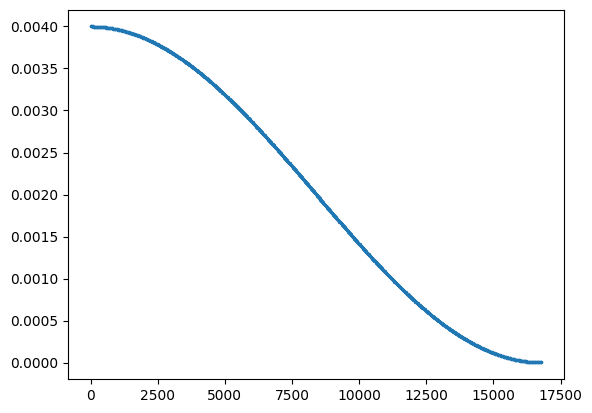


-----------------
train:913 valid:0

Epoch 1/600
28/28 - 120s - loss: 4.9104 - categorical_accuracy: 0.0268 - 120s/epoch - 4s/step
Epoch 2/600
28/28 - 1s - loss: 4.5073 - categorical_accuracy: 0.0446 - 686ms/epoch - 24ms/step
Epoch 3/600
28/28 - 1s - loss: 4.3175 - categorical_accuracy: 0.0580 - 647ms/epoch - 23ms/step
Epoch 4/600
28/28 - 1s - loss: 4.2337 - categorical_accuracy: 0.0703 - 623ms/epoch - 22ms/step
Epoch 5/600
28/28 - 1s - loss: 4.0889 - categorical_accuracy: 0.0982 - 625ms/epoch - 22ms/step
Epoch 6/600
28/28 - 1s - loss: 3.9163 - categorical_accuracy: 0.1027 - 606ms/epoch - 22ms/step
Epoch 7/600
28/28 - 1s - loss: 3.9272 - categorical_accuracy: 0.1094 - 622ms/epoch - 22ms/step
Epoch 8/600
28/28 - 1s - loss: 3.8620 - categorical_accuracy: 0.1027 - 639ms/epoch - 23ms/step
Epoch 9/600
28/28 - 1s - loss: 3.7073 - categorical_accuracy: 0.1451 - 611ms/epoch - 22ms/step
Epoch 10/600
28/28 - 1s - loss: 3.7026 - categorical_accuracy: 0.1395 - 617ms/epoch - 22ms/step
Epoch 11/600

(<keras.engine.functional.Functional at 0x78d4b451ea90>,
 <keras.callbacks.History at 0x78d4b4539f70>)

In [95]:
train_folds(CFG,temp_df)

In [96]:
test_df = temp_df[temp_df['split']=='test']
test_files = temp_df[temp_df['split']=='test']['tfr_path'].tolist()
print(f" Test Files length: {len(test_files)}")
NUM_C = 100
batch_size= 32
test_ds = get_tfrec_dataset(test_files, NUM_C = NUM_C, batch_size=batch_size, max_len=MAX_LEN, drop_remainder=False, repeat=False, shuffle=False)

 Test Files length: 100


In [97]:
def get_xy(ds):
    X,Y = [],[]
    for x,y in ds:
        X.append(x)
        Y.append(y.numpy().argmax(-1))
    return np.vstack(X),np.hstack(Y)
xtest,ytest = get_xy(test_ds)

In [98]:
best_model  = get_model(CFG.NUM_CLASSES,dim = 192)
best_model.load_weights('/kaggle/working/islr-fp16-192-8-seed42-last.h5')

In [99]:
y_pred = best_model.predict(xtest).argmax(-1)

4/4 [==============================] - 2s 108ms/step


In [100]:
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,confusion_matrix
print(f"Test Accuracy: {(accuracy_score(ytest,y_pred)*100):.2f} %")

Test Accuracy: 82.00 %


In [101]:
!pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


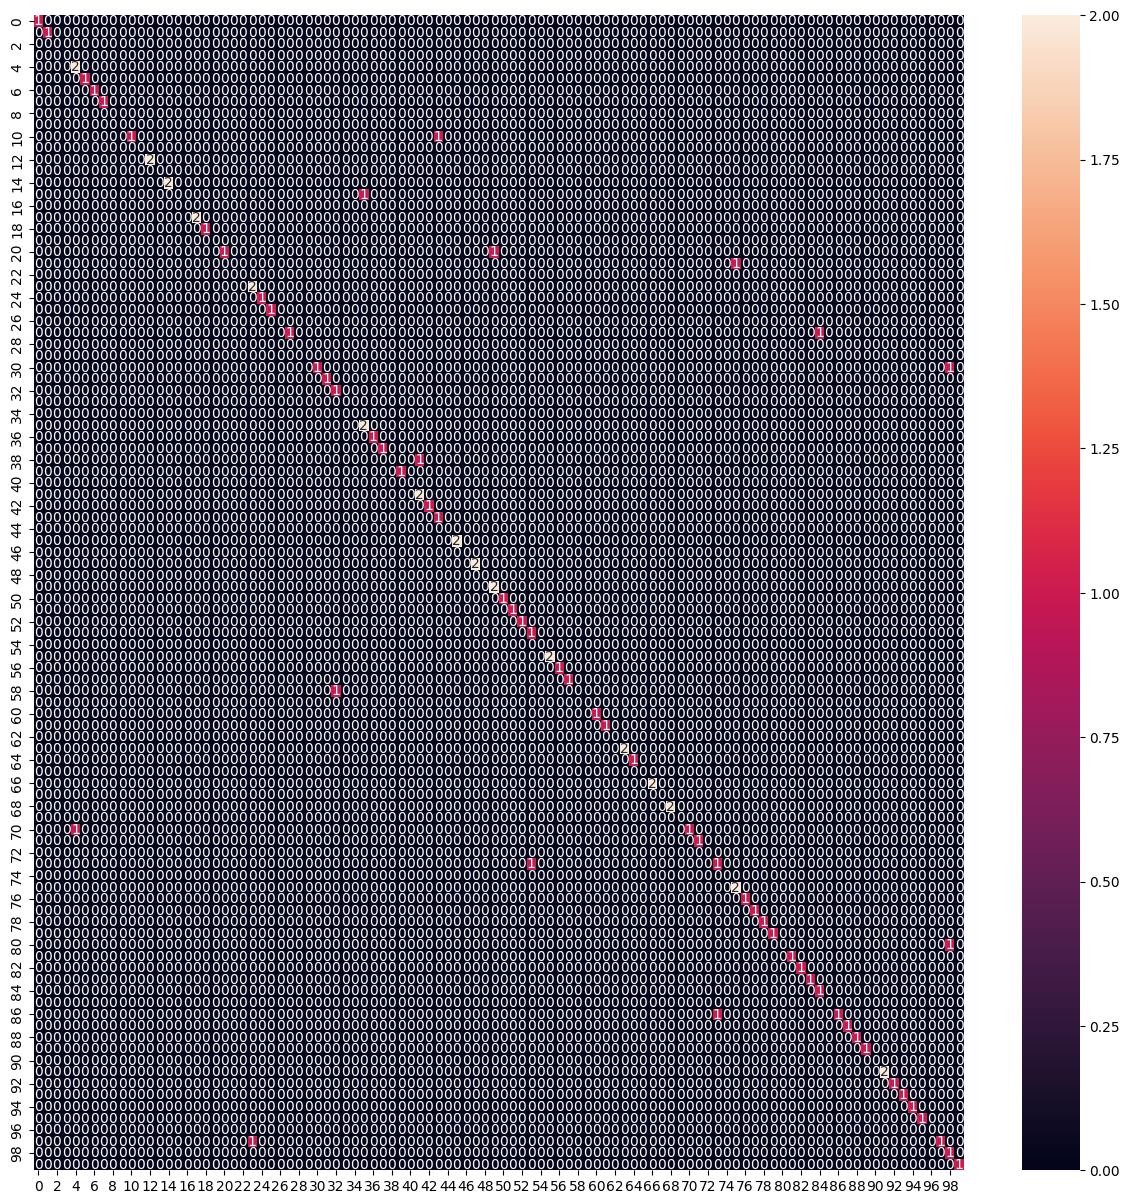

In [102]:
import seaborn as sns
cm = confusion_matrix(ytest, y_pred,labels = test_df['label'].tolist())

plt.figure(figsize = (15,15))
sns.heatmap(cm, annot=True,)
plt.savefig("Confusion Matrix (WLASL-100).png")
plt.show()
